In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
torch.manual_seed(123)

In [28]:
def load_data():
    # class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    from torchvision import datasets, transforms
    data_path = '../data-unversioned/ch7/'
    cifar10 = datasets.CIFAR10(
        data_path, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468),
                                (0.2470, 0.2435, 0.2616))
        ]))
    cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
    label_map = {0: 0, 2: 1}
    class_names = ['airplane', 'bird']
    cifar2 = [(img, label_map[label])
            for img, label in cifar10
            if label in [0, 2]]
    cifar2_val = [(img, label_map[label])
                for img, label in cifar10_val
                if label in [0, 2]]
    return cifar2, cifar2_val, class_names, data_path

In [30]:
cifar2, cifar2_val, classnames, data_path = load_data()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
len(cifar2), len(cifar2_val)

(10000, 2000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


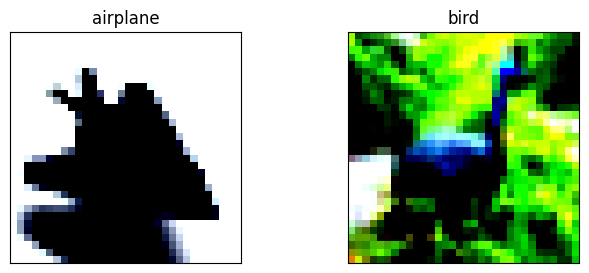

In [10]:
class_names = ['airplane','bird']
fig = plt.figure(figsize=(8,3))
for i in range(len(class_names)):
    ax = fig.add_subplot(1, 2, i+1, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next( img for img, label in cifar2 if label==i )
    plt.imshow(img.permute(1,2,0))

In [11]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [12]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [13]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

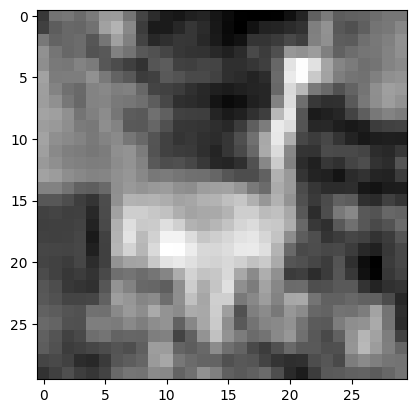

In [14]:
plt.imshow(output[0,0].detach(), cmap='gray')

In [15]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [16]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

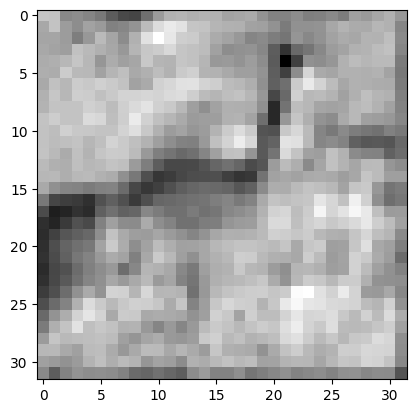

In [17]:
plt.imshow(output[0,0].detach(), cmap='gray')

In [18]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    #
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32,2)
)

In [19]:
numel_list = [p.numel() for p in model.parameters() ]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [25]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [20]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # [8,8,8] flatten to [512]
    nn.Flatten(),
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32,2)
)

In [21]:
numel_list = [p.numel() for p in model.parameters() ]
output = model(img.unsqueeze(0))
output.shape, sum(numel_list), numel_list

(torch.Size([1, 2]), 18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

自定义module

In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [23]:
model = Net()
numel_list = [p.numel() for p in model.parameters() ]
output = model(img.unsqueeze(0))
output.shape, sum(numel_list), numel_list

(torch.Size([1, 2]), 18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

函数式api

In [24]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [25]:
img, _ = cifar2[0]
model = Net()
numel_list = [p.numel() for p in model.parameters() ]
output = model(img.unsqueeze(0))
output, output.shape, sum(numel_list), numel_list

(tensor([[-0.2399, -0.0774]], grad_fn=<AddmmBackward0>),
 torch.Size([1, 2]),
 18090,
 [432, 16, 1152, 8, 16384, 32, 64, 2])

In [26]:
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader))) 

In [12]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs=100, optimizer=optimizer, 
              model=model,loss_fn=loss_fn, train_loader=train_loader)

2024-01-22 15:41:19.380953 Epoch 1, Training loss 0.5663522696419127
2024-01-22 15:41:35.406811 Epoch 10, Training loss 0.3359696027959228
2024-01-22 15:41:53.271416 Epoch 20, Training loss 0.2968581629217051
2024-01-22 15:42:11.054126 Epoch 30, Training loss 0.27089682297342144
2024-01-22 15:42:28.832682 Epoch 40, Training loss 0.2474160701226277
2024-01-22 15:42:46.697300 Epoch 50, Training loss 0.22680534892211293
2024-01-22 15:43:04.460979 Epoch 60, Training loss 0.21172933688588963
2024-01-22 15:43:22.308644 Epoch 70, Training loss 0.19332018660701764
2024-01-22 15:43:40.054391 Epoch 80, Training loss 0.17902872839551062
2024-01-22 15:43:57.852114 Epoch 90, Training loss 0.16429594097433575
2024-01-22 15:44:15.666153 Epoch 100, Training loss 0.15085889738361546


In [24]:
def val_accuracy(model, val_data):
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    return correct, total, correct/total

In [14]:
val_accuracy(model, cifar2)

(9421, 10000, 0.9421)

In [15]:
val_accuracy(model, cifar2_val)

(1782, 2000, 0.891)

move to GPU

In [17]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
device

device(type='cuda')

In [19]:
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels =labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader))) 

In [21]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs=100, optimizer=optimizer, 
              model=model,loss_fn=loss_fn, train_loader=train_loader)

2024-01-22 15:51:29.106763 Epoch 1, Training loss 0.5896235040039014
2024-01-22 15:51:33.043480 Epoch 10, Training loss 0.32639059585750485
2024-01-22 15:51:37.396928 Epoch 20, Training loss 0.29666915825407975
2024-01-22 15:51:41.751751 Epoch 30, Training loss 0.2685545354037528
2024-01-22 15:51:46.103643 Epoch 40, Training loss 0.24670047284501373
2024-01-22 15:51:50.476841 Epoch 50, Training loss 0.22388316819052786
2024-01-22 15:51:54.977144 Epoch 60, Training loss 0.21078999881531782
2024-01-22 15:51:59.364154 Epoch 70, Training loss 0.19390074941952518
2024-01-22 15:52:03.717232 Epoch 80, Training loss 0.178854536146495
2024-01-22 15:52:08.037423 Epoch 90, Training loss 0.16661411481108634
2024-01-22 15:52:12.544954 Epoch 100, Training loss 0.15118648292152745


In [23]:
def val_accuracy(model, val_data):
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    return correct, total, correct/total

In [26]:
val_accuracy(model, cifar2_val)

(1802, 2000, 0.901)

In [27]:
val_accuracy(model, cifar2)

(9411, 10000, 0.9411)

In [31]:
torch.save(model.state_dict(), data_path+'birds_vs_airplanes.pt')

In [32]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path+'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

In [34]:
val_accuracy(loaded_model, cifar2_val)

(1802, 2000, 0.901)

flatten layer

In [35]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # [8,8,8] flatten to [512]
    nn.Flatten(),
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32,2)
).to(device=device)

In [36]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
# model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs=100, optimizer=optimizer, 
              model=model,loss_fn=loss_fn, train_loader=train_loader)

2024-01-22 16:08:37.932937 Epoch 1, Training loss 0.5957894613788386
2024-01-22 16:08:41.985805 Epoch 10, Training loss 0.3384874618736802
2024-01-22 16:08:46.417817 Epoch 20, Training loss 0.29864101178327185
2024-01-22 16:08:50.826496 Epoch 30, Training loss 0.2700960218526755
2024-01-22 16:08:55.163197 Epoch 40, Training loss 0.24978292681229342
2024-01-22 16:08:59.533426 Epoch 50, Training loss 0.2316029093637588
2024-01-22 16:09:03.886769 Epoch 60, Training loss 0.2176830871090008
2024-01-22 16:09:08.273514 Epoch 70, Training loss 0.20094428861596783
2024-01-22 16:09:12.643628 Epoch 80, Training loss 0.187894730478715
2024-01-22 16:09:17.046000 Epoch 90, Training loss 0.1717396497394249
2024-01-22 16:09:21.400519 Epoch 100, Training loss 0.16046540301506687


In [38]:
val_accuracy(model, cifar2_val), val_accuracy(model, cifar2)

((1784, 2000, 0.892), (9389, 10000, 0.9389))

优化

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [7]:
def get_numel(model):
    return sum(p.numel() for p in model.parameters())

In [8]:
get_numel(NetWidth())

38386

In [35]:
from datetime import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, device):
    start_time = datetime.now()
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels =labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.now(), epoch,
                loss_train / len(train_loader)))
    print(f'Elapsed time: {datetime.now() - start_time}')

In [9]:
from datetime import datetime
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader, device):
    start_time = datetime.now()
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels =labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            # L2 norm
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.now(), epoch,
                loss_train / len(train_loader)))
    print(f'Elapsed time: {datetime.now() - start_time}')

In [43]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def val_accuracy(model, val_loader):
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    return correct, total, correct/total

def validate(model, train_loader, val_loader):
    _, _, train_acc = val_accuracy(model, train_loader)
    _, _, val_acc = val_accuracy(model, val_loader)
    acc_dict = {}
    acc_dict['train'] = train_acc
    acc_dict['val'] = val_acc
    return acc_dict

In [49]:
import collections
all_acc_dict = collections.OrderedDict()

In [53]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs=100, optimizer=optimizer, 
              model=model,loss_fn=loss_fn, train_loader=train_loader, device=device)
all_acc_dict['baseline'] = validate(model, train_loader=train_loader, val_loader=val_loader)
all_acc_dict['baseline']

2024-01-24 12:00:02.709539 Epoch 1, Training loss 0.5630612003195817
2024-01-24 12:00:06.638799 Epoch 10, Training loss 0.34214245048677844
2024-01-24 12:00:11.008720 Epoch 20, Training loss 0.29611600119217185
2024-01-24 12:00:15.379001 Epoch 30, Training loss 0.27253122637226324
2024-01-24 12:00:19.750349 Epoch 40, Training loss 0.25075833641799394
2024-01-24 12:00:24.070979 Epoch 50, Training loss 0.23312547660557328
2024-01-24 12:00:28.424069 Epoch 60, Training loss 0.21267659478126819
2024-01-24 12:00:32.792587 Epoch 70, Training loss 0.1996675565079519
2024-01-24 12:00:37.163516 Epoch 80, Training loss 0.18461197076045024
2024-01-24 12:00:41.526751 Epoch 90, Training loss 0.17002926021814346
2024-01-24 12:00:45.868795 Epoch 100, Training loss 0.15565122915491178
Elapsed time: 0:00:43.788789


(0.9376, 0.896)

In [55]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(n_epochs=100, optimizer=optimizer, 
              model=model,loss_fn=loss_fn, train_loader=train_loader, device=device)
all_acc_dict['l2reg'] = validate(model, train_loader=train_loader, val_loader=val_loader)
all_acc_dict['l2reg']

2024-01-24 12:01:37.863333 Epoch 1, Training loss 0.6188710394558633
2024-01-24 12:01:43.127505 Epoch 10, Training loss 0.3495003622808274
2024-01-24 12:01:48.967714 Epoch 20, Training loss 0.316137229181399
2024-01-24 12:01:54.817759 Epoch 30, Training loss 0.2944931996286295
2024-01-24 12:02:00.582331 Epoch 40, Training loss 0.27914595015489374
2024-01-24 12:02:06.378638 Epoch 50, Training loss 0.2645485370781771
2024-01-24 12:02:12.137088 Epoch 60, Training loss 0.25116410120657295
2024-01-24 12:02:17.961460 Epoch 70, Training loss 0.2406635275881761
2024-01-24 12:02:23.766587 Epoch 80, Training loss 0.2300451297763806
2024-01-24 12:02:29.588185 Epoch 90, Training loss 0.21930206334514982
2024-01-24 12:02:35.390955 Epoch 100, Training loss 0.21481029319155748
Elapsed time: 0:00:58.353722


(0.9218, 0.888)

In [59]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs=100, optimizer=optimizer, 
              model=model,loss_fn=loss_fn, train_loader=train_loader, device=device)
all_acc_dict['netwidth'] = validate(model, train_loader=train_loader, val_loader=val_loader)
all_acc_dict['netwidth']

2024-01-24 12:05:53.945523 Epoch 1, Training loss 0.5621667817519729
2024-01-24 12:05:59.733504 Epoch 10, Training loss 0.31553455712688955
2024-01-24 12:06:06.187587 Epoch 20, Training loss 0.27570902442286727
2024-01-24 12:06:12.641600 Epoch 30, Training loss 0.2527541716102582
2024-01-24 12:06:19.083703 Epoch 40, Training loss 0.22673922103301736
2024-01-24 12:06:25.522306 Epoch 50, Training loss 0.20174943375739324
2024-01-24 12:06:31.958702 Epoch 60, Training loss 0.17789550419825656
2024-01-24 12:06:38.379533 Epoch 70, Training loss 0.15319192708487722
2024-01-24 12:06:44.785568 Epoch 80, Training loss 0.13411235486625867
2024-01-24 12:06:51.222354 Epoch 90, Training loss 0.11143466977366975
2024-01-24 12:06:57.629073 Epoch 100, Training loss 0.09376359491306506
Elapsed time: 0:01:04.568969


(0.9715, 0.902)

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [64]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs=100, optimizer=optimizer, 
              model=model,loss_fn=loss_fn, train_loader=train_loader, device=device)
all_acc_dict['net_dropout'] = validate(model, train_loader=train_loader, val_loader=val_loader)
all_acc_dict['net_dropout']

2024-01-24 12:11:24.374102 Epoch 1, Training loss 0.5562606376067848
2024-01-24 12:11:30.309402 Epoch 10, Training loss 0.3785175374548906
2024-01-24 12:11:36.897898 Epoch 20, Training loss 0.3444850856711151
2024-01-24 12:11:43.470418 Epoch 30, Training loss 0.32437988593699824
2024-01-24 12:11:50.260840 Epoch 40, Training loss 0.30808632417469267
2024-01-24 12:11:56.980454 Epoch 50, Training loss 0.29686240196987324
2024-01-24 12:12:03.785914 Epoch 60, Training loss 0.2761805542999772
2024-01-24 12:12:10.371322 Epoch 70, Training loss 0.2658464037309027
2024-01-24 12:12:16.931510 Epoch 80, Training loss 0.25631762390873236
2024-01-24 12:12:23.504159 Epoch 90, Training loss 0.2508485304417124
2024-01-24 12:12:30.055469 Epoch 100, Training loss 0.2382374111159592
Elapsed time: 0:01:06.611516


(0.9031, 0.8855)

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1//2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [67]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs=100, optimizer=optimizer, 
              model=model,loss_fn=loss_fn, train_loader=train_loader, device=device)
all_acc_dict['net_batchnorm'] = validate(model, train_loader=train_loader, val_loader=val_loader)
all_acc_dict['net_batchnorm']

2024-01-24 12:13:48.385655 Epoch 1, Training loss 0.46646884330518684
2024-01-24 12:13:55.523868 Epoch 10, Training loss 0.2695293456410906
2024-01-24 12:14:03.661879 Epoch 20, Training loss 0.2070347483560538
2024-01-24 12:14:11.670766 Epoch 30, Training loss 0.1678675172530162
2024-01-24 12:14:19.788459 Epoch 40, Training loss 0.1335864959486351
2024-01-24 12:14:27.865571 Epoch 50, Training loss 0.1016511050569024
2024-01-24 12:14:35.788243 Epoch 60, Training loss 0.0783752711181333
2024-01-24 12:14:43.725817 Epoch 70, Training loss 0.058310148561266574
2024-01-24 12:14:51.618033 Epoch 80, Training loss 0.043803587164373915
2024-01-24 12:14:59.507706 Epoch 90, Training loss 0.034350328378758996
2024-01-24 12:15:07.397143 Epoch 100, Training loss 0.027633254232395228
Elapsed time: 0:01:19.926462


(0.9929, 0.888)

In [70]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [71]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs=100, optimizer=optimizer, 
              model=model,loss_fn=loss_fn, train_loader=train_loader, device=device)
all_acc_dict['net_res'] = validate(model, train_loader=train_loader, val_loader=val_loader)
all_acc_dict['net_res']

2024-01-24 12:25:59.712877 Epoch 1, Training loss 0.6599109374034177
2024-01-24 12:26:05.950027 Epoch 10, Training loss 0.32637546073858903
2024-01-24 12:26:12.842010 Epoch 20, Training loss 0.2803625462541155
2024-01-24 12:26:19.679775 Epoch 30, Training loss 0.2432626311898611
2024-01-24 12:26:26.499709 Epoch 40, Training loss 0.21254647390288153
2024-01-24 12:26:33.338268 Epoch 50, Training loss 0.18095808594849458
2024-01-24 12:26:40.160205 Epoch 60, Training loss 0.1581254656052893
2024-01-24 12:26:46.981417 Epoch 70, Training loss 0.13817231964533497
2024-01-24 12:26:53.803602 Epoch 80, Training loss 0.11005691281122387
2024-01-24 12:27:00.643313 Epoch 90, Training loss 0.09066637453569729
2024-01-24 12:27:07.498484 Epoch 100, Training loss 0.07294821948596057
Elapsed time: 0:01:08.633479


(0.9836, 0.906)

In [77]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.bach_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.bach_norm.weight, 0.5)
        torch.nn.init.zeros_(self.bach_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.bach_norm(out)
        out = torch.relu(out)
        return out + x
    
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [78]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs=100, optimizer=optimizer, 
              model=model,loss_fn=loss_fn, train_loader=train_loader, device=device)
all_acc_dict['net_res_deep'] = validate(model, train_loader=train_loader, val_loader=val_loader)
all_acc_dict['net_res_deep']

2024-01-24 12:30:25.136611 Epoch 1, Training loss 1.6831458503273642
2024-01-24 12:33:29.299527 Epoch 10, Training loss 0.323849133625152
2024-01-24 12:36:54.496486 Epoch 20, Training loss 0.25695316745027613
2024-01-24 12:40:20.207292 Epoch 30, Training loss 0.20402635351582699
2024-01-24 12:43:45.921169 Epoch 40, Training loss 0.1512099778291526
2024-01-24 12:47:11.631000 Epoch 50, Training loss 0.11757566877136565
2024-01-24 12:50:37.359908 Epoch 60, Training loss 0.08580156742553612
2024-01-24 12:54:03.089550 Epoch 70, Training loss 0.06856950278138849
2024-01-24 12:57:28.817411 Epoch 80, Training loss 0.05954332779618395
2024-01-24 13:00:54.330150 Epoch 90, Training loss 0.042246097200149726
2024-01-24 13:04:19.507765 Epoch 100, Training loss 0.027672628899531995
Elapsed time: 0:34:14.865928


(0.9809, 0.871)

In [83]:
t_acc = [(k,v) for k,v in all_acc_dict.items()]
t_acc

[('baseline', (0.9376, 0.896)),
 ('l2reg', (0.9218, 0.888)),
 ('netwidth', (0.9715, 0.902)),
 ('net_dropout', (0.9031, 0.8855)),
 ('net_batchnorm', (0.9929, 0.888)),
 ('net_res', (0.9836, 0.906)),
 ('net_res_deep', (0.9809, 0.871))]

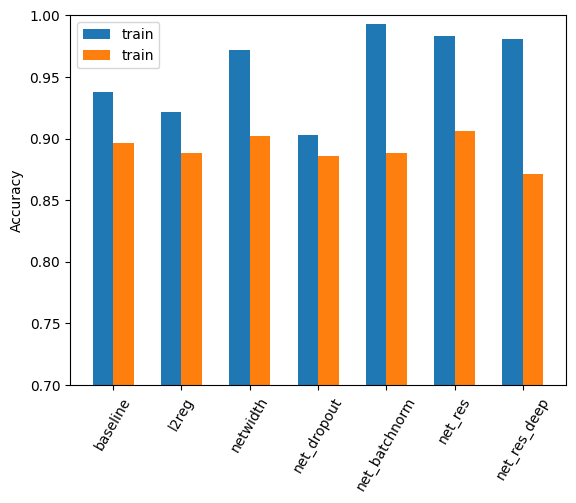

In [85]:
import numpy as np
t_acc = [v[0] for _, v in all_acc_dict.items()]
v_acc = [v[1] for _, v in all_acc_dict.items()]
width=0.3
num = len(t_acc)
plt.bar(np.arange(num), t_acc, width=width, label='train')
plt.bar(np.arange(num)+width, v_acc, width=width, label='train')
plt.xticks(np.arange(num) + width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylim(0.7, 1.0)
plt.ylabel('Accuracy')
plt.legend()